<center>
<div class="alert alert-block alert-info">
<h1>Time Series Prediction Using ARIMA</h1>
    </div>

<a id=menu></a>
## Menu

* [Imports](#imports)
* [Add Customers with Unknown ID](#add_nans)
* [Linear Regression](#linear_reg)
    * [Linear Regression Hyperparameter Tuning](#lrhypertune)

* [ARIMA](#arima)
    - [Dicky Fuller Test](#dicky_fuller)
    - [Optimize ARIMA Model](#optimize_model)
* [Summary](#summary)


<a id=imports></a>
## Imports

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from datetime import datetime
import os

import statsmodels.api as sm

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima_model import  ARIMA
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [65]:
df = pd.read_csv('../cleaned_data/data_with_all_customer_ids.csv',index_col = 0)
df.head(2)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Date,Sales,Year,Month,Day,Quarter,Week,Week_day,Day_of_year
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009-12-01 00:00:00,83.4,2009,12,1,4,49,1,335
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-12-01 00:00:00,81.0,2009,12,1,4,49,1,335


In [3]:
#drop products with no description
df = df[df['Description'].notna()]
#any weird description
(pd.Series(df['Description'].unique()).apply(lambda x: len(x))<2).sum()

0

In [4]:
df.shape

(997246, 17)

### Investigate Sales (response variable)

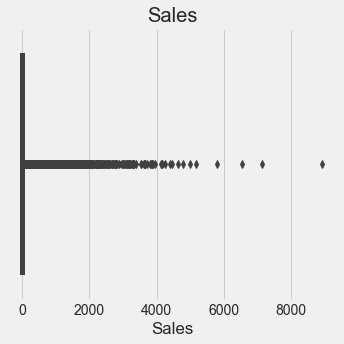

In [62]:
#display sales, the target variable, boxplot
plt.style.use('fivethirtyeight')
plt.subplots(figsize=(5,5))
sns.boxplot(x=df.Sales)
plt.title('Sales');


In [66]:
#look at distibution of sales
df.loc[:,['Sales']].describe().apply(lambda x: x.apply(lambda x: format(x,'f')))

,Sales
count,997246.000000
mean,19.148402
std,73.039130
min,0.001000
25%,4.130000
50%,10.000000
75%,17.700000
max,38970.000000


>There is a great variation in sales' min and max values

In [67]:
#explore that big outlier above 35000
df[df.Sales>35000]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Date,Sales,Year,Month,Day,Quarter,Week,Week_day,Day_of_year
748132,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.5,15098.0,United Kingdom,2011-06-10 00:00:00,38970.0,2011,6,10,2,23,4,161


In [46]:
#explore price range of this product
df[df.Description.str.contains('PICNIC BASKET WICKER')]['Price'].unique()

array([  8.5 ,   9.95,   4.25,   3.75,   5.95,   4.95,   7.62,   3.  ,
       649.5 ,   2.  ,  21.23,   8.47,   8.29,  20.79,  10.79,   8.95])

In [68]:
#are there any product for that price of 649.5
df[df.Price==649.5]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Date,Sales,Year,Month,Day,Quarter,Week,Week_day,Day_of_year
748132,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.5,15098.0,United Kingdom,2011-06-10 00:00:00,38970.0,2011,6,10,2,23,4,161
748143,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.5,15098.0,United Kingdom,2011-06-10 00:00:00,649.5,2011,6,10,2,23,4,161


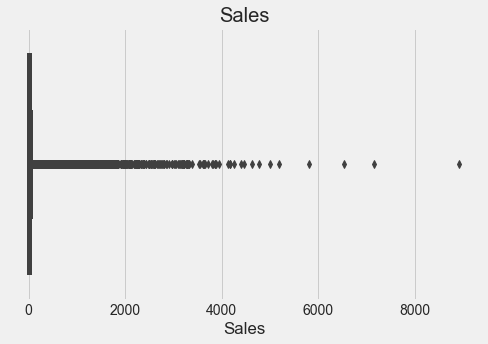

In [69]:
#these two entries do not make sense one with quantity of 60 and the other with quantity 1 for the same price, I think 
#these should be deleted
df = df[df.Price!=649.5]
#display sales
plt.subplots(figsize=(7,5))
sns.boxplot(x=df.Sales)
plt.title('Sales');

In [8]:
#save new df
df.to_csv('../cleaned_data/data_with_all_customer_ids_clean_sales.csv')

* A time series shows how a single variable changes over time and these observations are taken over regular intervals, like weekly or monthly sales. The series would have the date at regular intervals as the index and the variable being measured, which is sales in my case.
* First thing to do is to create my time series with date as the index.
* Then the data needs to be at regular intervals, in my case I will be investigating the daily sum of sales

In [73]:
#copy the dataframe
df_data = df.copy()
df_data.InvoiceDate = pd.to_datetime(df_data.InvoiceDate) #make sure the date is a datetime object

In [74]:
#change index to be the dates without the time
df_data = df_data.set_index('InvoiceDate')#InvoiceDate has time
df_data.index = df_data.index.normalize()#gets rid of time stamp
df_data.head(2)

,Invoice,StockCode,Description,Quantity,Price,Customer ID,Country,Date,Sales,Year,Month,Day,Quarter,Week,Week_day,Day_of_year
InvoiceDate,,,,,,,,,,,,,,,,
2009-12-01,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,6.95,13085.0,United Kingdom,2009-12-01 00:00:00,83.4,2009,12,1,4,49,1,335
2009-12-01,489434,79323P,PINK CHERRY LIGHTS,12,6.75,13085.0,United Kingdom,2009-12-01 00:00:00,81.0,2009,12,1,4,49,1,335


In [75]:
#create a df with only sales
df_sales = df_data[['Sales']]
#resample daily
df_sales_day = df_sales.resample('d').sum()
df_sales_day.head()

,Sales
InvoiceDate,
2009-12-01,51433.87
2009-12-02,61047.85
2009-12-03,70378.72
2009-12-04,38946.04
2009-12-05,9518.43


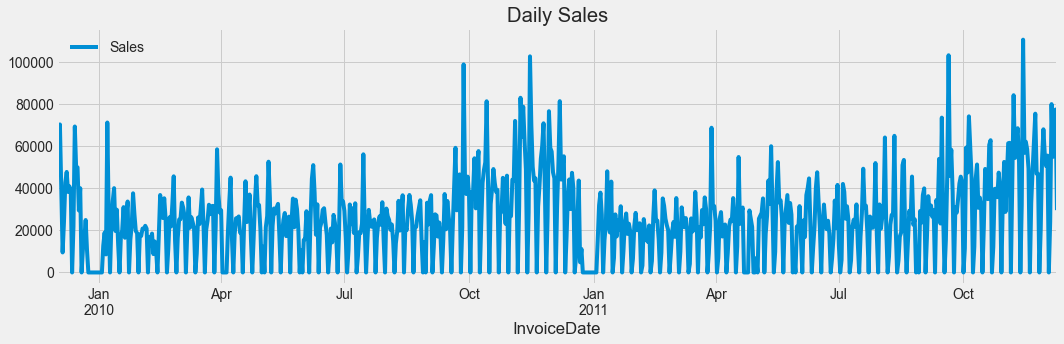

In [76]:
df_sales_day.plot(figsize=(15,5))
plt.title('Daily Sales');

# Time Series
One of the most important tasks for any retail store company is to analyze the performance of its stores. The main challenge faced by any retail store is predicting in advance the sales and quantity of inventory required at each store to avoid over-stocking and under-stocking. This helps the business to provide the best customer experience and avoid getting into losses, thus ensuring the store is sustainable for operation.

In this notebook I will be predicting sales and in the next one quantity. Date’ is one of the important factors influencing sales and it acts as an independent variable. To put it simply, this is a time-series data i.e a series of data points ordered at equal time intervals.

The features that need to be analyzed in a time series are: 

- Trend: it is the long term change in the mean of the series, meaning it is the overall direction the data is traveling.
- Seasonality: is the repeating the short-term cycle in the series.
- Noise: is the random variation in the series.


### Types of models
1. Additive model ==> y(t) = trend + seasonality + noise
In the additive model, the behavior is linear where changes over time are consistently made by the same amount, meaning the linear seasonality has the same amplitude and frequency.

2. Multiplicative model ==>  y(t) = trend * seasonality * noise
the multiplicative model has an increasing or decreasing amplitude and/or frequency over time.

This means if the seasonal peaks change in amplitude over time then it is a multiplicative model, if they stay relatively the same then it is additive. I will plot daily sales to see which model it is.

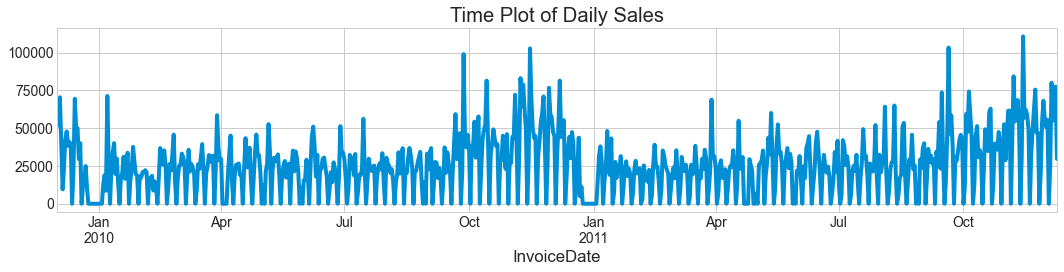

In [77]:
#plot the target variable y which is daily sales
#create the target variable y
y=df_sales_day.Sales
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(15, 4),
    titlesize=18,
    titleweight='bold',
)
y.plot()
plt.title('Time Plot of Daily Sales');

For additive data the general trend increases at a steady, and constant speed and the seasonal ups and downs not to increase or decrease in extent over time (the peaks stay the same over time). For multiplicative data the trend will be increasing at an increasing rate and seasonal fluctuations get bigger over time (the peaks and troughs increase over time).
My data seems is an additive model because the seasonal peaks do not increase in amplitude or frequency, however I can use decompose to get the trend and seasonality over time.


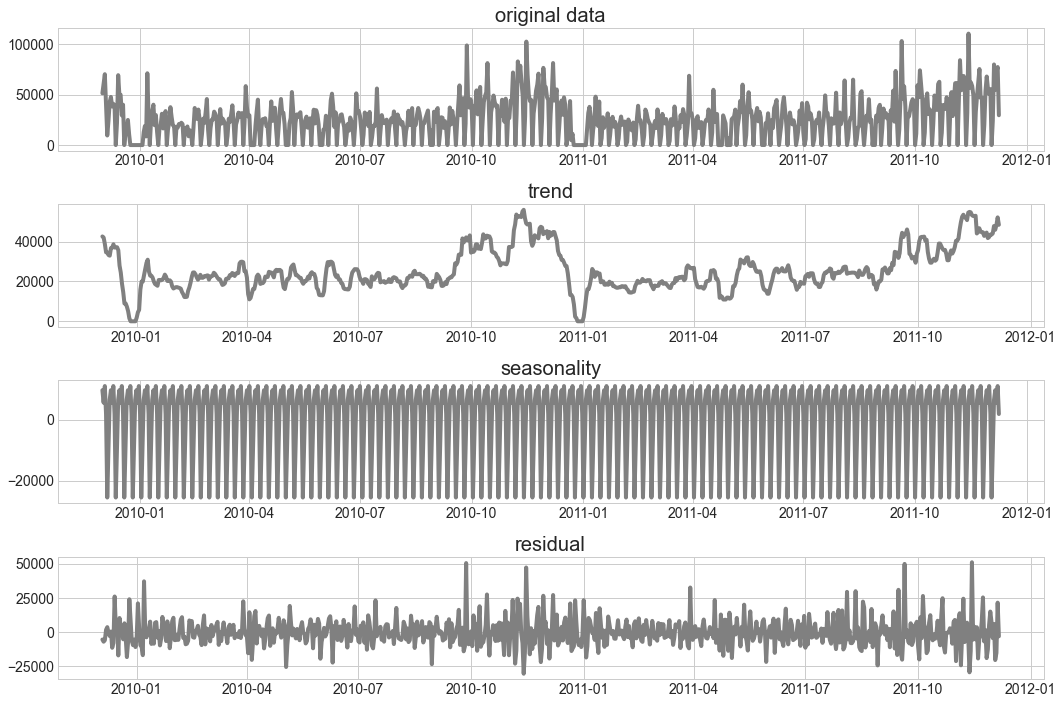

In [78]:
from statsmodels.tsa.seasonal import seasonal_decompose

dec = seasonal_decompose(y, model='additive')

trend = dec.trend
season = dec.seasonal
residual = dec.resid

f,ax = plt.subplots(4,1,figsize=(15,10))
ax[0].plot(y,color='gray')
ax[0].set_title('original data')
ax[1].plot(trend,color='gray')
ax[1].set_title('trend')
ax[2].plot(season,label='seasonal',color='gray')
ax[2].set_title('seasonality')
ax[3].plot(residual,label='residual',color='gray')
ax[3].set_title('residual');

<AxesSubplot:xlabel='InvoiceDate'>

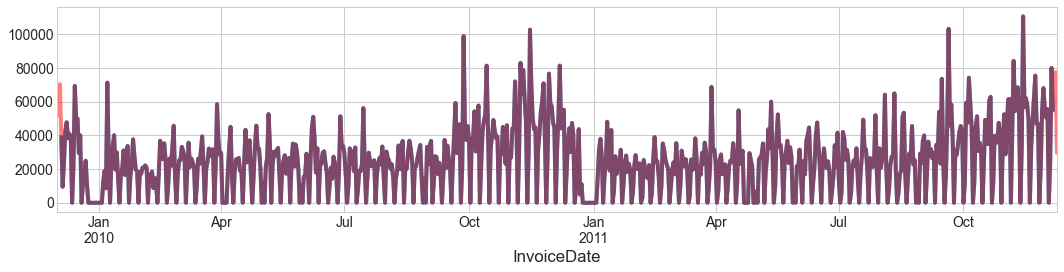

In [79]:
#I can reconstruct the series by adding the decomposed pieces
(trend+season+residual).plot()
y.plot(color='r', alpha=0.5)

The time series is composed of three components: a trend-cycle component, a seasonal component, and a remainder component containing anything else in the time series. This is done to improve understanding of the series and improve forecast accuracy.
So here y = trend + seasonal + remainder

Observations: the seasonal component does not change over time. It remains the same over the two years, which makes sense since I know that there is a seasonal spike before Christmas in both years. For the trend I notice that there is a downward trend right after the spike in sales before Christmas

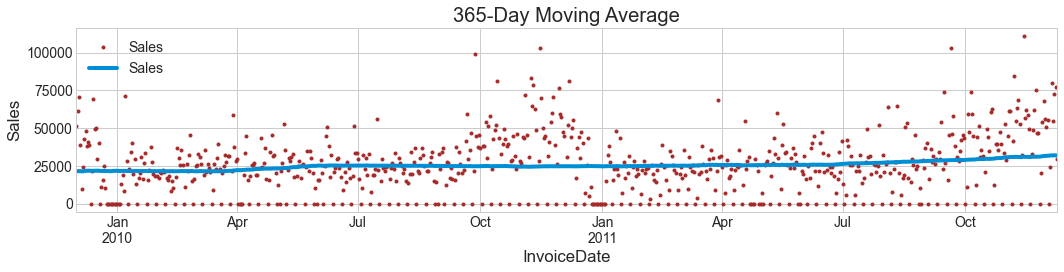

In [80]:
#plot trend in data using rolling average over 365 day window
moving_average = df_sales_day.rolling(window=365,       # 365-day window
                                    center=True,      # puts the average at the center of the window
                                    min_periods=183).mean()   # choose about half the window size
                
ax = df_sales_day.plot(style='.',color='brown')
moving_average.plot(title="365-Day Moving Average",ax=ax)
ax.set_ylabel('Sales');


The mean is trending up slightly.

### Stationarity 
Another thing I need to check is if the time series data is stationary.  A series is non-stationary due to a unit root which means it shows a systematic pattern that is unpredictable. A stationary series  has constant mean, constant variance and constant covariance over time.  
The most common stationary test is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the p-value is less than the significance level,0.05 here, then I reject the Null and infer that the data is not stationary.
There are are also the rolling mean and the Dicky Fuller Test

[Menu](#menu)
<a id = kpssr></a>
### The kpss test: 
The kpss test tests the H0 that the series is stationary

In [17]:

from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(y,regression='c') #since there is not trend I will use c

KPSS Statistic: 0.5498604581026878
p-value: 0.030436833760655896
num lags: 20
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


The p_value < 0.05 so we can reject the H0 and the data is stationary. A major disadvantage for the KPSS test is that it has a high rate of Type I errors meaning it tends to reject the null hypothesis too often. 

[Menu](#menu)
<a id = dicky_fuller></a>
### The Dicky_Fuller_test: 
The Dicky_Fuller_test tests the H0 that the data is not stationary and the alternative hypothesis is that the data is stationary. If the p-value is less than the critical value, 0.05 I will reject the null hypothesis and say that data is stationary.

In [18]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result= adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p_value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}: {value}')
        #print(f'Result: The series is {"" if p_value < 0.05 else"not"}stationary')
        
adf_test(y)


ADF Statistic: -2.2854231716687905
p_value: 0.17671239565109853
Critial Values:
   1%: -3.439490435810785
Critial Values:
   5%: -2.8655738086413374
Critial Values:
   10%: -2.568918067209286


p_value is not significant so we cannot reject the null hypothesis and the series is not stationary. Since this is an additive model so no transformation is needed but because it is not stationary I have to make it stationary using differencing

In [19]:
#Run the kpss test again on the differenced dataset to see if that makes it stationary
kpss_test(y.diff().dropna())

KPSS Statistic: 0.05488324273683995
p-value: 0.1
num lags: 20
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


# Linear Regression

I will use linear regression to construct a forecasting model. The linear regression model learns how to make weighted sum of its inputs to predict its target, in this case the target is sales. This is called the ordinary least squared because the model tries to minimizes the squared error between predictions and target. It looks like

sales = weight1*var1+weight2*var2 + bias

For the variables:
There are two kinds of features unique to time series: lag feature and time step feature

### Time Step

In [21]:
#add step feature to series so we can model time dependence
df_sales_day['time_step'] = np.arange(len(df_sales_day.index))
df_sales_day.head()

,Sales,time_step
InvoiceDate,,
2009-12-01,51433.87,0
2009-12-02,61047.85,1
2009-12-03,70378.72,2
2009-12-04,38946.04,3
2009-12-05,9518.43,4


sns.regplot performs the following linear regression model

target(sales) = w1*time_step+bias

where time_step is the x_axis and target variable (sales) is the y_axis. This is how it would look like

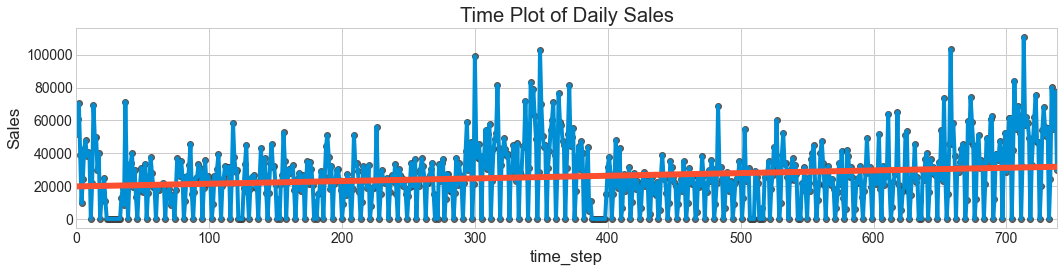

In [22]:
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(15, 4),
    titlesize=18,
    titleweight='bold',
)
plt.plot(df_sales_day.time_step,df_sales_day.Sales)
sns.regplot(data=df_sales_day,x='time_step',y='Sales',ci=None, scatter_kws=dict(color='0.25'))
plt.title('Time Plot of Daily Sales');

From the above graph I can see that sales are generally higher from year 2009 to 2011. Now I will use this feature to predict sales using LinearRegression

In [32]:
#predict from time step
X = df_sales_day.loc[:,['time_step']]
y = df_sales_day.loc[:,'Sales'] #target

model = LinearRegression().fit(X,y)
#predict
y_pred = pd.Series(model.predict(X),index = X.index)

#get slope and intercept
model.coef_,model.intercept_

(array([16.22113494]), 19800.663150001878)

So the model its using is:  
target(sales) = 16.22 * time_step + 19800.7

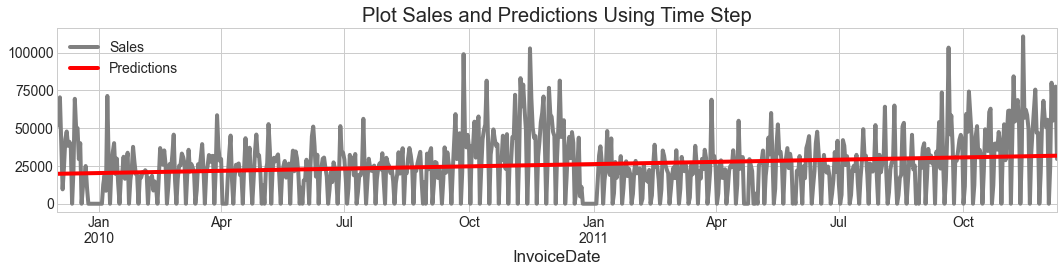

In [33]:
#plot predictions against actual results
y.plot(color='gray')
y_pred.plot(label='Predictions', color='red')
plt.legend()
plt.title('Plot Sales and Predictions Using Time Step');

In [35]:
model.score(X,y), np.sqrt(mean_squared_error(y, y_pred))

(0.03269328270064897, 18822.941469643276)

## Lag feature
target = weight * lag + bias

Each observation is plotted against previous observations. This is done to see if sales from one day are correlated with sales from the previous day.Lag features let you model serial dependence. A time series has serial dependence when an observation can be predicted from previous observations.

In [36]:
#add lag feature
df_sales_day['lag_1'] = df_sales_day.Sales.shift(1)
df_sales_day.head()

,Sales,time_step,lag_1
InvoiceDate,,,
2009-12-01,51433.87,0,NaN
2009-12-02,61047.85,1,51433.87
2009-12-03,70378.72,2,61047.85
2009-12-04,38946.04,3,70378.72
2009-12-05,9518.43,4,38946.04


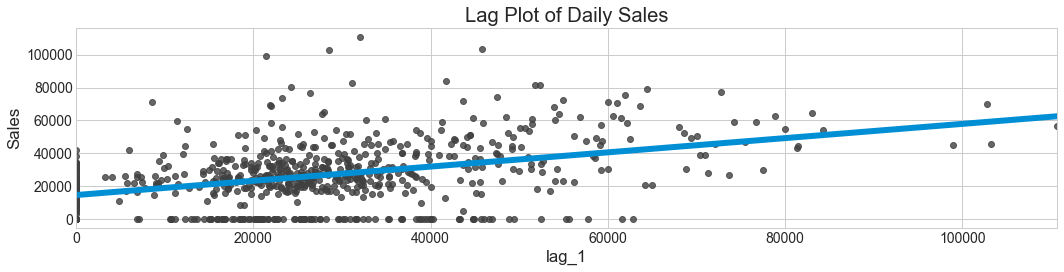

In [37]:
#plot
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(15, 4),
    titlesize=18,
    titleweight='bold',
)
#plt.plot(df_sales_day.lag_1,df_sales_day.Sales)
sns.regplot(data=df_sales_day,x='lag_1',y='Sales',ci=None, scatter_kws=dict(color='0.25'))
plt.title('Lag Plot of Daily Sales');

There is a correlation between sales from day to sales from previous day. This means that high sales on one day means high sales the next day. So now I will use the lag feature to predict sales, here I will drop the missing value

In [38]:
#predict from time step
X = df_sales_day.loc[:,['lag_1']]
X = X.dropna()
#create target feature
y = df_sales_day.loc[:,'Sales'] 
#drop corresponding target value where X is missing
y,X = y.align(X, join='inner')
model = LinearRegression().fit(X,y)
#predict
y_pred = pd.Series(model.predict(X),index = X.index)

#get slope and intercept and score
model.coef_,model.intercept_,model.score(X,y),np.sqrt(mean_squared_error(y,y_pred))

(array([0.43298487]),
 14588.699943452553,
 0.1879229856150989,
 17237.289325585352)

So the model its using is:
target(sales) = 0.43 * time_step + 14588.7

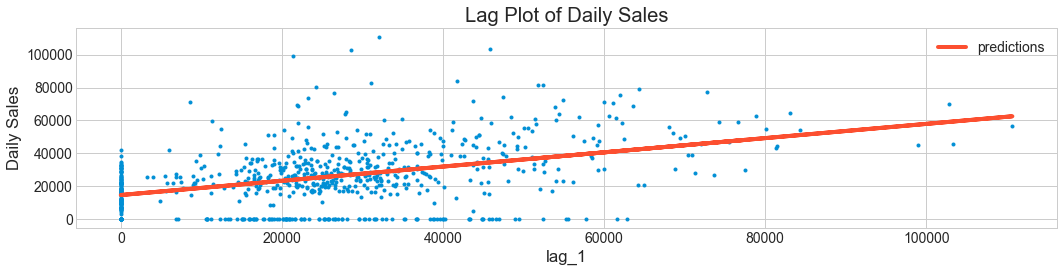

In [39]:
#plot predictions against actual results
plt.plot(X.lag_1,y,'.')
plt.plot(X.lag_1,y_pred,label='predictions')
plt.title('Lag Plot of Daily Sales')
plt.legend()
plt.xlabel('lag_1')
plt.ylabel('Daily Sales');

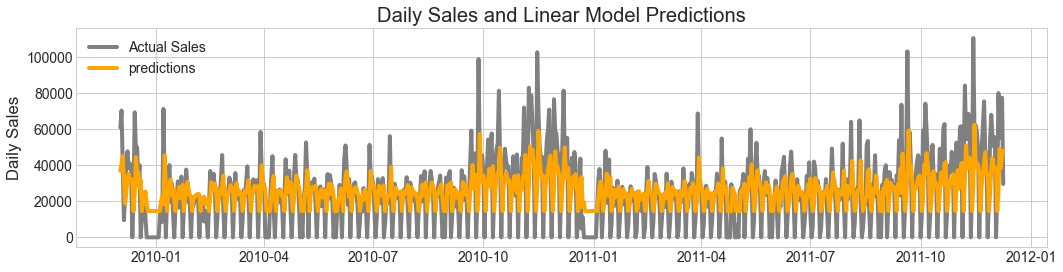

In [41]:
#plot sales and predcition
plt.plot(y,color='gray',label='Actual Sales')
plt.plot(y_pred,color='orange',label='predictions')
plt.title('Daily Sales and Linear Model Predictions')
plt.ylabel('Daily Sales')
plt.legend();

From the lag plot I can see that there is a linear relationship between sales and sales from previous day and the prediction plot shows how well we can predict the series across time using previous day price.

In [335]:
model.score(X,y),np.sqrt(mean_squared_error(y,))

0.1879229856150989

use lags gives better predictions and better score than just using the time step

In [48]:
X = df_sales_day.drop(['Sales'],axis=1)
X = df_sales_day.loc[:,['lag_1']]
X = X.dropna()
y = df_sales_day.loc[:,'Sales']
y,X = y.align(X,join='inner')

model = LinearRegression().fit(X,y)
y_pred = model.predict(X)
model.score(X,y),np.sqrt(mean_squared_error(y,y_pred)),mean_absolute_error(y,y_pred)

(0.1879229856150989, 17237.289325585352, 12857.422413038787)

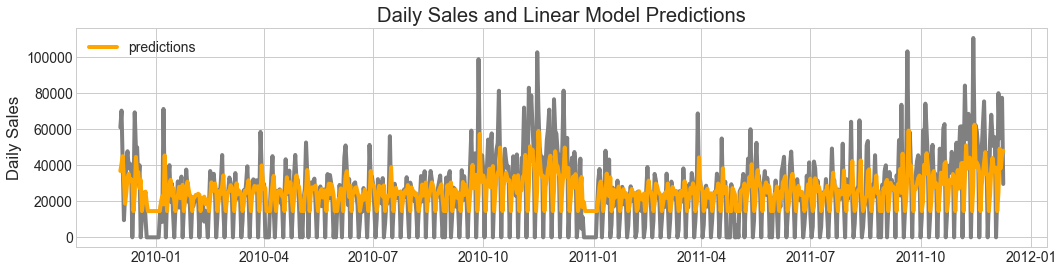

In [51]:
#plot sales and predcition
y_pred = pd.Series(y_pred,index=y.index)
plt.plot(y,color='gray')
plt.plot(y_pred,color='orange',label='predictions')
plt.title('Daily Sales and Linear Model Predictions')
plt.ylabel('Daily Sales')
plt.legend();

I get slightly better predictions and better score. Now I will try ARIMA

[Menu](#menu)
<a id='arima'></a>
### Autoregressive Integrated Moving Average or ARIMA

In [82]:
#bring back series and sales only
df_sales_day = df_sales_day.loc[:,['Sales']]
df_sales_day.head()

,Sales
InvoiceDate,
2009-12-01,51433.87
2009-12-02,61047.85
2009-12-03,70378.72
2009-12-04,38946.04
2009-12-05,9518.43


<AxesSubplot:xlabel='Sales'>

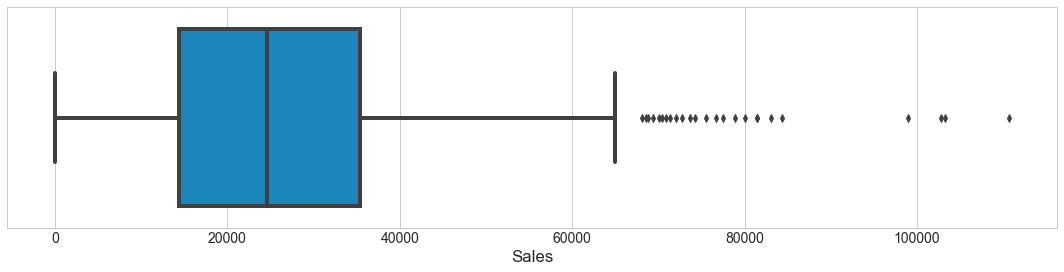

In [84]:
sns.boxplot(df_sales_day.Sales)

I can use ARMA, ARIMA or SARIMA models. ARMA needs to have a series that is stationary but since this one is not I will use ARIMA.
ARIMA is a class of models that explains a given time series based on its own past values. 
Arima stands for Autoregressive Integrated Moving Average, which means the following:
AR: stands for Autoregression, which means a model that uses the dependent relationship between an observation and some number of lagged observations.  
I: Integrated which means subtracting an observation from an observation at the previous time step in order to make the time series stationary, meaning differencing  
MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

There are three parameters that need to be tuned:
- p is the number of lags of Y to be used as predictors
- d is the minimum number of differencing needed to make the series stationary. A d =0 means the series is stationary 
- q refers to the number of lagged forecast errors that should go into the Model.


P value is determined from the pacf plot  
q value is determined from the acf plot

- The Autocorrelation function (ACF) plot shows how a given time series is correlated with its past values. The ACF is the plot used to see the correlation between the points, up to and including the lag unit.
- Partial correlation, or PACF is a conditional correlation. It is a summary of the relationship between an observation with observations at prior time steps. 

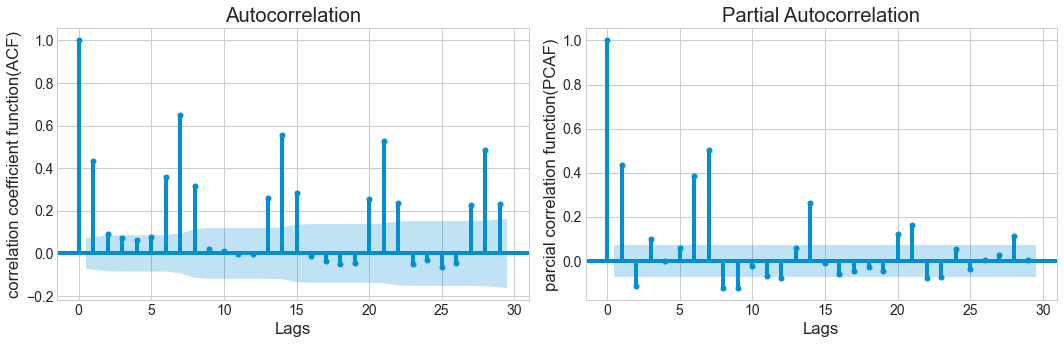

In [86]:
#autocorrelation function or ACF graph
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
#The ACF plot tells how many MA terms are required to remove any autocorrelation in the stationarized series, which is q
f,ax = plt.subplots(1,2,figsize=(15,5))
plot_acf(df_sales_day,ax=ax[0])
ax[0].set_xlabel('Lags')
ax[0].set_ylabel('correlation coefficient function(ACF)')
#To find out need needs any AR terms or p by inspecting the Partial Autocorrelation (PACF) plot.
plot_pacf(df_sales_day,ax=ax[1])
plt.xlabel('Lags')
plt.ylabel('parcial correlation function(PCAF)');


- From the ACF graph the time series is significantly positively correlated with its past values at 1 and 2 lags.  
- From the PACF lag 1, 2 and 3 are significant. Also, when auto-correlation decrease too fast it may indicate over_differencing and if it decrease too slow(stays positive for more than 10 lags) it indicates under_differencing. In the graph above, the autocorrelation decreases slowly up to 9 lags.
From the PACF we get the AR or p term, from ACF we get the MA or q term. So the model will be run with p= 1, q= 3, and d=1.

RMSE=  27765.237009808465
MAE=  21525.84483819558


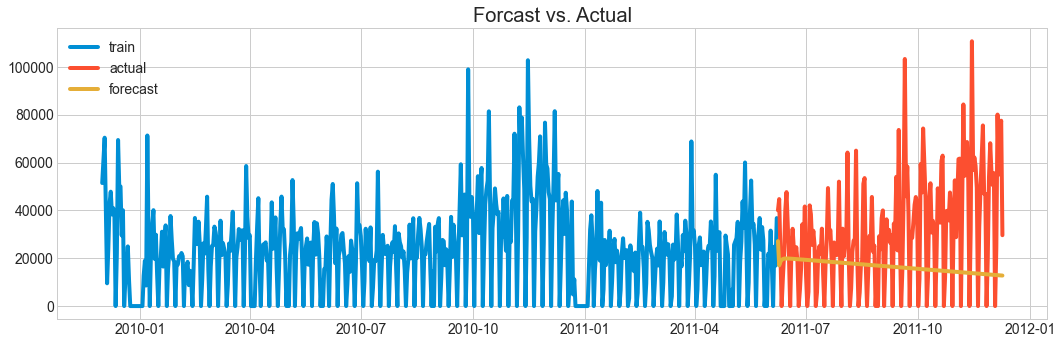

In [87]:

X = df_sales_day.values
size = int(len(df_sales_day)*0.75)
train, test = X[0:size], X[size:len(X)]
predictions = []
model = ARIMA(train, order=(1,1,3))
model_arima = model.fit()
fc, er, ci = model_arima.forecast(len(test))#forecast 15 steps
fc_series = pd.Series(fc, index=df_sales_day[size:].index)
print('RMSE= ',np.sqrt(mean_squared_error(test, fc)))
print('MAE= ',mean_absolute_error(test,fc))
#plot forcast
plt.figure(figsize=(15,5))
plt.plot(df_sales_day[0:size], label='train')
plt.plot(df_sales_day[size:], label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forcast vs. Actual')
plt.legend();

Now I need to investigate the best values for p and q

In [89]:
#split data into 80% training and 20% testing data
split = int(len(df_sales_day) * 0.8)#make sure to split data on integer
train,test = df_sales_day.values[:split],df_sales_day.values[split:]

#make train into list
past_values = [x for x in train]
predictions = list()
    
#timestep-wise comparison between test data and one-step prediction ARIMA model. 
for i in range(len(test)):
    model = ARIMA(train, order=(1,1,1))
    model_fit = model.fit(disp=0) #disp means convergence information is printed.
    pred = model_fit.forecast()[0]
    predictions.append(pred)
    past_values.append(test[i])

rmse = np.sqrt(mean_squared_error(test, predictions))
mae=mean_absolute_error(test,predictions)
print('Root Mean Squared Error={}'.format(rmse))
  #  return rmse,mae

Root Mean Squared Error=24764.92041856935


In [90]:
"""
Function takes in training and test sets and a tuple of p,d,q for arima model and fits and predicts 
returns the root mean squared error
"""
def evaluate_arima(data, order):
    #creat train and test data
    split = int(len(data) * 0.8)#make sure to split data on integer
    train,test = data[0:split],data[split:len(data)]
    #print(train.isna().sum(),test.isna().sum())
    #make train into list
    past_values = [x for x in train]
    predictions = list()
    
    #timestep-wise comparison between test data and one-step prediction ARIMA model. 
    for i in range(len(test)):
        model = ARIMA(train, order = order)
        model_fit = model.fit(disp=0) #disp means convergence information is printed.
        pred = model_fit.forecast()[0]
        predictions.append(pred)
        past_values.append(test[i])

    rmse = np.sqrt(mean_squared_error(test, predictions))
    mae=mean_absolute_error(test,predictions)
   
    return rmse,mae

In [91]:
"""
Function that takes training, test sets and a list of values for p, d and q to test
Function loops through the values of p, d and q and creates a tuple of these values and calls evaluate_arima 
    that returns the root mean square error and then print the p,d,q for the model that gave the least RMSE
"""
def evaluate_model(data, p_val, d_val, q_val):
    #intialize best score to a large value
    best_score, best_mae, best_pdq_se, best_pdq_ae = float('inf'), float('inf'), (),()#best_pdq_se best p q and d using square error
    for p in p_val:
        for d in d_val:
            for q in q_val:
                order=(p,d,q)
                print(order)
                try:
                    #run arima
                    rmse, mae=evaluate_arima(data, order)
                    
                    #get error
                    if rmse < best_score:
                        best_score, best_pdq_se = rmse, order
                    if mae < best_mae:
                        best_mae,best_pdq_ae = mae, order
                        
                        #print the order and its error
                    print('ARIMA order: {}, RMSE: {}'.format(order,rmse))
                    print('Arima order: {}, MAE: {}'.format(order,mae))
                except:
                    continue
    return print('Best ARIMA order: {} with error = {}'.format(best_pdq_se, best_score)),print('Best ARIMA order: {} with absolute error = {}'.format(best_pdq_ae, best_mae))
                 

In [92]:
#list of p, d and q values
p_values = [x for x in range(0,3)]
d_values = [x for x in range(0,3)]
q_values = [x for x in range(0,3)]


#run function
evaluate_model(df_sales_day.values,p_values, d_values, q_values)

(0, 0, 0)
ARIMA order: (0, 0, 0), RMSE: 25464.43435216484
Arima order: (0, 0, 0), MAE: 20118.019999588407
(0, 0, 1)
ARIMA order: (0, 0, 1), RMSE: 23886.551815655526
Arima order: (0, 0, 1), MAE: 18840.80592673759
(0, 0, 2)
ARIMA order: (0, 0, 2), RMSE: 23836.708814573372
Arima order: (0, 0, 2), MAE: 18809.289576997005
(0, 1, 0)
ARIMA order: (0, 1, 0), RMSE: 23158.398079659706
Arima order: (0, 1, 0), MAE: 18561.720091387968
(0, 1, 1)
ARIMA order: (0, 1, 1), RMSE: 26322.513857128364
Arima order: (0, 1, 1), MAE: 20855.779547243797
(0, 1, 2)
ARIMA order: (0, 1, 2), RMSE: 24437.494634936873
Arima order: (0, 1, 2), MAE: 19250.771380332644
(0, 2, 0)
ARIMA order: (0, 2, 0), RMSE: 24603.520380705304
Arima order: (0, 2, 0), MAE: 20221.376529642555
(0, 2, 1)
ARIMA order: (0, 2, 1), RMSE: 23143.725795480146
Arima order: (0, 2, 1), MAE: 18568.272973662613
(0, 2, 2)
ARIMA order: (0, 2, 2), RMSE: 26017.31693824735
Arima order: (0, 2, 2), MAE: 20593.88880903029
(1, 0, 0)
ARIMA order: (1, 0, 0), RMSE: 2

(None, None)

In [484]:
evaluate_arima(df_sales_day.values,(0,2,1))

(23143.725795480146, 18568.272973662613)

In [124]:
p=0
d=2
q=1

model = ARIMA(df_sales_day.values, order=(p,d,q))
model_fit = model.fit()
l = int(len(y))
model_pred = model_fit.forecast(len(y))[0]
len(model_pred)

739

In [131]:
len(test)

148

In [162]:
split = int(len(df_sales_day) * 0.8)#make sure to split data on integer
train,test = df_sales_day.values[:split],df_sales_day.values[split:]

p=1
d=2
q=2

model = ARIMA(train, order=(p,d,q))
model_fit = model.fit()

model_pred = model_fit.forecast(len(test))[0]
#model_pred

ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

In [150]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D2.y   No. Observations:                  589
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -6625.889
Method:                       css-mle   S.D. of innovations          18491.285
Date:                Thu, 03 Feb 2022   AIC                          13257.779
Time:                        09:45:05   BIC                          13270.914
Sample:                             2   HQIC                         13262.896
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6302      4.470      0.141      0.888      -8.130       9.391
ma.L1.D2.y    -1.0000      0.004   -239.294      0.000      -1.008      -0.992
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [96]:
p=0
d=1
q=0

model = ARIMA(df_sales_day.values, order=(p,d,q))
model_fit = model.fit()
model_pred = model_fit.predict(len(y))
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  738
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -8369.569
Method:                           css   S.D. of innovations          20372.479
Date:                Wed, 02 Feb 2022   AIC                          16743.137
Time:                        17:18:40   BIC                          16752.345
Sample:                             1   HQIC                         16746.688
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.5513    749.921     -0.039      0.969   -1499.370    1440.268
==============================================================================
"""

In [151]:
df_sales_day[size:].index

DatetimeIndex(['2011-06-08', '2011-06-09', '2011-06-10', '2011-06-11',
               '2011-06-12', '2011-06-13', '2011-06-14', '2011-06-15',
               '2011-06-16', '2011-06-17',
               ...
               '2011-11-30', '2011-12-01', '2011-12-02', '2011-12-03',
               '2011-12-04', '2011-12-05', '2011-12-06', '2011-12-07',
               '2011-12-08', '2011-12-09'],
              dtype='datetime64[ns]', name='InvoiceDate', length=185, freq='D')

In [156]:
len(df_sales_day.values[split:])

148

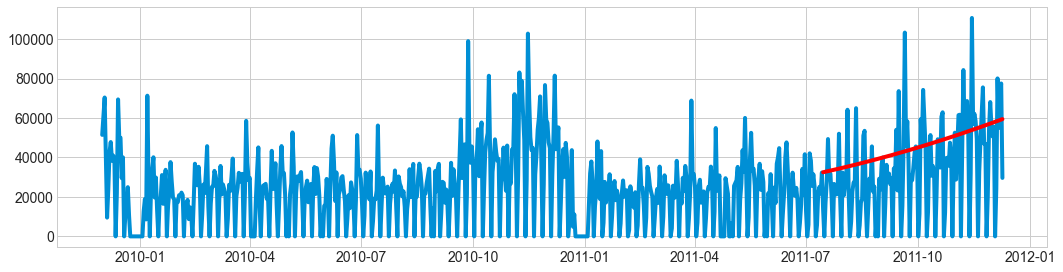

In [158]:
forecast = pd.Series(model_pred,index = df_sales_day[split:].index)
plt.plot(df_sales_day)
plt.plot(forecast, color='red')

[Back to Menu](#menu)

[Menu](#menu)
<a id=summary></a>
## Summary:
1. The data with the missing customer ID was added to the dataframe
2. Perform several visualizations on daily, weekly, monthly, quarterly, and yearly sales, as well as for customer count.
3. Sales variable was right skewed so I used values from 1% to 99% of the variable and then took the log of it to normalize it so models can be run on it.
4. Models tried are Linear Regression, KNearest Neighbor, and Random Forest, but their accuracy was low and residuals were not normal
5. Next try ARIMA on the daily sales
6. to test if the data is stationary I ran the dicky fuller test and the rolling mean test. Result was that the data is not stationary and needed to be differenced once
7. ACF and PACF graphs were used to get values for p and q to get a preliminary graph
8. Optimize values for p, d, and q.
